In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cwd = os.getcwd()
cwd

'/Users/deanlee/GitHub/FigureOneLab/kinker'

In [3]:
meta = pd.read_csv(cwd+'/data/Metadata.txt', sep='\t')
meta.drop([0], axis=0, inplace=True)
meta.rename(columns={'NAME':'CellID', 'Cell_line':'CellLine', 'Pool_ID':'Pool', 'Cancer_type':'Indication'}, inplace=True)
meta

/var/folders/gq/zhkl55292md4w3kdwkb01qjh0000gn/T/ipykernel_1095/2744822609.py:1: DtypeWarning: Columns (4,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(cwd+'/data/Metadata.txt', sep='\t')


,CellID,CellLine,Pool,Indication,Genes_expressed,Discrete_cluster_minpts5_eps1.8,Discrete_cluster_minpts5_eps1.5,Discrete_cluster_minpts5_eps1.2,CNA_subclone,SkinPig_score,...,EMTII_score,EMTIII_score,IFNResp_score,p53Sen_score,EpiSen_score,StressResp_score,ProtMatu_score,ProtDegra_score,G1/S_score,G2/M_score
1,AAACCTGAGACATAAC-1-18,NCIH2126_LUNG,18,Lung Cancer,4318,NaN,NaN,NaN,NaN,0.166,...,-0.935,-0.935,0.13,0.619,1.869,-0.004,0.805,0.896,0.424,-1.125
2,AACGTTGTCACCCGAG-1-18,NCIH2126_LUNG,18,Lung Cancer,5200,NaN,NaN,NaN,NaN,-0.213,...,-1.027,-1.027,0.066,1.049,1.267,0.252,1.299,1.61,0.624,-0.048
3,AACTGGTAGACACGAC-1-18,NCIH2126_LUNG,18,Lung Cancer,4004,NaN,NaN,NaN,NaN,-0.101,...,-0.677,-0.677,0.304,0.822,2.401,0.141,0.451,1.225,-0.795,0.064
4,AACTGGTAGGGCTTGA-1-18,NCIH2126_LUNG,18,Lung Cancer,4295,NaN,NaN,NaN,NaN,-0.014,...,-0.735,-0.735,0.094,0.834,2.282,0.15,0.267,0.892,-0.238,1.118
5,AACTGGTAGTACTTGC-1-18,NCIH2126_LUNG,18,Lung Cancer,4842,NaN,NaN,NaN,NaN,0.006,...,-0.821,-0.821,0.034,0.96,1.4,-0.012,-0.276,-0.428,0.267,0.791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53509,c4722,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,3343,NaN,NaN,NaN,NaN,0.018,...,-0.505,-0.505,1.657,1.583,3.85,0.539,0.473,0.544,-1.079,-1.349
53510,c4724,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6977,NaN,NaN,NaN,NaN,-0.098,...,-0.876,-0.876,0.669,1.086,3.046,0.799,0.49,1.319,-0.37,0.057
53511,c4731,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,6638,NaN,NaN,NaN,NaN,-0.112,...,-0.112,-0.112,0.61,0.693,2.289,0.65,0.729,1.143,-0.508,0.501
53512,c4735,JHU006_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4052,NaN,NaN,NaN,NaN,-0.244,...,1.981,1.981,0.523,-0.309,0.267,0.822,1.049,0.777,0.296,-0.936


In [4]:
# the first three rows are CellID, CellLine, and Pool
# only need the first row, CellID
pd.read_csv(cwd+'/data/UMIcount_data.txt', nrows=10, sep='\t', header=None)

,0,1,2,3,4,5,6,7,8,9,...,56973,56974,56975,56976,56977,56978,56979,56980,56981,56982
0,NaN,AAACCTGAGACATAAC-1-18,AAACCTGCACAACGCC-1-18,AAACCTGCAGACAAGC-1-18,AAACCTGCAGCTCGAC-1-18,AAACCTGCATGGATGG-1-18,AAACCTGGTACGAAAT-1-18,AAACGGGAGATACACA-1-18,AAACGGGCAGGTGCCT-1-18,AAACGGGGTTTAGGAA-1-18,...,c4781,c4784,c4785,c4786,c4787,c4788,c4789,c4793,c4800,c4812
1,Cell_line,NCIH2126_LUNG,SW579_THYROID,C32_SKIN,SW579_THYROID,NCIH446_LUNG,HEC251_ENDOMETRIUM,MFE319_ENDOMETRIUM,SKNAS_AUTONOMIC_GANGLIA,NCIH2452_PLEURA,...,SCC25_UPPER_AERODIGESTIVE_TRACT,SCC25_UPPER_AERODIGESTIVE_TRACT,SCC25_UPPER_AERODIGESTIVE_TRACT,SCC25_UPPER_AERODIGESTIVE_TRACT,93VU_UPPER_AERODIGESTIVE_TRACT,JHU029_UPPER_AERODIGESTIVE_TRACT,SCC9_UPPER_AERODIGESTIVE_TRACT,JHU029_UPPER_AERODIGESTIVE_TRACT,SCC9_UPPER_AERODIGESTIVE_TRACT,SCC9_UPPER_AERODIGESTIVE_TRACT
2,Pool_ID,18,18,18,18,18,18,18,18,18,...,custom,custom,custom,custom,custom,custom,custom,custom,custom,custom
3,A1BG,0,1,1,1,0,2,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,A1BG-AS1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,A1CF,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,A2M,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,A2M-AS1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,A2ML1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,A2ML1-AS1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
counts_cellid = pd.read_csv(cwd+'/data/UMIcount_data.txt', nrows=1, sep='\t', header=None)
counts_cellid = counts_cellid.transpose()
counts_cellid.drop([0], inplace=True)
counts_cellid

,0
1,AAACCTGAGACATAAC-1-18
2,AAACCTGCACAACGCC-1-18
3,AAACCTGCAGACAAGC-1-18
4,AAACCTGCAGCTCGAC-1-18
5,AAACCTGCATGGATGG-1-18
...,...
56978,c4788
56979,c4789
56980,c4793
56981,c4800


In [6]:
%%time
counts = pd.read_csv(cwd+'/data/UMIcount_data.txt', sep='\t', skiprows=3, header=None, index_col=0)
counts = counts.transpose()
counts

CPU times: user 5min 34s, sys: 24.9 s, total: 5min 59s
Wall time: 6min 22s


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,...,PRICKLE4,RABL6,RAET1E-AS1,RGS5,SERPINA3,SPATA13,TBC1D26,TIMM10B,TMBIM4,TMEM256-PLSCR3
1,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56978,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,4,4,0
56979,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
56980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
56981,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
counts.index = counts_cellid[0]
counts.index.name = None
a = counts.index.isin(meta['CellID'])
counts = counts[a]
counts

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A3GALT2,A4GALT,...,PRICKLE4,RABL6,RAET1E-AS1,RGS5,SERPINA3,SPATA13,TBC1D26,TIMM10B,TMBIM4,TMEM256-PLSCR3
AAACCTGAGACATAAC-1-18,0,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,1,0,0
AAACCTGCACAACGCC-1-18,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
AAACCTGCAGACAAGC-1-18,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,1,0,0,0,0
AAACCTGCAGCTCGAC-1-18,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCATGGATGG-1-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c4788,1,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,4,4,0
c4789,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
c4793,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
c4800,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [8]:
counts.index.equals(meta.CellID)

False

In [9]:
meta = meta.set_index('CellID')
meta = meta.reindex(index=counts.index)
meta

,CellLine,Pool,Indication,Genes_expressed,Discrete_cluster_minpts5_eps1.8,Discrete_cluster_minpts5_eps1.5,Discrete_cluster_minpts5_eps1.2,CNA_subclone,SkinPig_score,EMTI_score,EMTII_score,EMTIII_score,IFNResp_score,p53Sen_score,EpiSen_score,StressResp_score,ProtMatu_score,ProtDegra_score,G1/S_score,G2/M_score
AAACCTGAGACATAAC-1-18,NCIH2126_LUNG,18,Lung Cancer,4318,NaN,NaN,NaN,NaN,0.166,-0.045,-0.935,-0.935,0.13,0.619,1.869,-0.004,0.805,0.896,0.424,-1.125
AAACCTGCACAACGCC-1-18,SW579_THYROID,18,Thyroid Cancer,5021,NaN,NaN,SW579_THYROID_1,NaN,-0.056,0.776,0.953,0.953,-0.266,-0.334,-1.125,-0.039,-0.243,-0.642,-0.173,1.365
AAACCTGCAGACAAGC-1-18,C32_SKIN,18,Skin Cancer,3047,NaN,NaN,NaN,NaN,1.092,0.617,-0.034,-0.034,0.318,0.57,-0.165,0.074,0.25,0.096,-0.367,-1.135
AAACCTGCAGCTCGAC-1-18,SW579_THYROID,18,Thyroid Cancer,2765,NaN,NaN,SW579_THYROID_1,NaN,-0.601,1.038,1.952,1.952,0.341,-0.253,-0.552,0.921,2.876,1.645,0.226,0.469
AAACCTGCATGGATGG-1-18,NCIH446_LUNG,18,Lung Cancer,2064,NaN,NaN,NaN,NaN,-0.251,-0.325,0.258,0.258,-0.044,-1.256,-0.367,-0.317,0.79,1.925,0.138,-0.384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c4788,JHU029_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,5929,JHU029_UPPER_AERODIGESTIVE_TRACT_1,JHU029_UPPER_AERODIGESTIVE_TRACT_1,JHU029_UPPER_AERODIGESTIVE_TRACT_1,NaN,-0.317,-0.39,0.023,0.023,-0.1,-0.604,-0.358,-0.123,0.067,0.804,0.135,0.264
c4789,SCC9_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,3531,SCC9_UPPER_AERODIGESTIVE_TRACT_2,SCC9_UPPER_AERODIGESTIVE_TRACT_2,SCC9_UPPER_AERODIGESTIVE_TRACT_2,SCC9_UPPER_AERODIGESTIVE_TRACT_2,0.238,1.176,2.094,2.094,0.014,-0.045,-0.05,0.214,0.238,-0.514,-1.021,-1.243
c4793,JHU029_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4029,JHU029_UPPER_AERODIGESTIVE_TRACT_1,JHU029_UPPER_AERODIGESTIVE_TRACT_3,NaN,NaN,-0.164,-0.163,-0.405,-0.405,0.01,-0.008,0.045,0.265,0.054,-0.466,0.345,0.804
c4800,SCC9_UPPER_AERODIGESTIVE_TRACT,custom,Head and Neck Cancer,4009,SCC9_UPPER_AERODIGESTIVE_TRACT_1,SCC9_UPPER_AERODIGESTIVE_TRACT_1,SCC9_UPPER_AERODIGESTIVE_TRACT_4,SCC9_UPPER_AERODIGESTIVE_TRACT_1,0.205,0.217,0.833,0.833,-0.257,-0.856,-0.593,0.152,0.022,0.684,0.684,0.624


In [10]:
counts.index.equals(meta.index)

True

In [11]:
%%time
adata = anndata.AnnData(X=counts,
                        obs=meta,
                        var=counts.columns.to_frame())
adata

CPU times: user 6.44 ms, sys: 3.49 ms, total: 9.93 ms
Wall time: 14.8 ms


AnnData object with n_obs × n_vars = 53513 × 30314
    obs: 'CellLine', 'Pool', 'Indication', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score'
    var: 0

In [12]:
adata.var.drop(columns=[0], inplace=True)
adata.var.index.name = None
adata.var

""
A1BG
A1BG-AS1
A1CF
A2M
A2M-AS1
...
SPATA13
TBC1D26
TIMM10B
TMBIM4


In [13]:
%%time
adata.X = scipy.sparse.csr_matrix(adata.X.copy())
adata.layers['counts'] = scipy.sparse.csr_matrix(adata.X.copy())

CPU times: user 9.69 s, sys: 12.9 s, total: 22.6 s
Wall time: 33.5 s


In [14]:
%%time
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=200)

CPU times: user 2.48 s, sys: 6.43 s, total: 8.91 s
Wall time: 12.5 s


In [15]:
adata

AnnData object with n_obs × n_vars = 53513 × 23081
    obs: 'CellLine', 'Pool', 'Indication', 'Genes_expressed', 'Discrete_cluster_minpts5_eps1.8', 'Discrete_cluster_minpts5_eps1.5', 'Discrete_cluster_minpts5_eps1.2', 'CNA_subclone', 'SkinPig_score', 'EMTI_score', 'EMTII_score', 'EMTIII_score', 'IFNResp_score', 'p53Sen_score', 'EpiSen_score', 'StressResp_score', 'ProtMatu_score', 'ProtDegra_score', 'G1/S_score', 'G2/M_score', 'n_genes'
    var: 'n_cells'
    layers: 'counts'

In [16]:
del counts

In [17]:
%%time
random.seed(17)
scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key='Pool')
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
scvi_model.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/149:   0%|                                      | 0/149 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 149/149: 100%|█| 149/149 [4:10:57<00:00, 98.19s/it, v_num=1, train_loss_st

`Trainer.fit` stopped: `max_epochs=149` reached.


Epoch 149/149: 100%|█| 149/149 [4:10:57<00:00, 101.06s/it, v_num=1, train_loss_s
CPU times: user 8h 13min 26s, sys: 1h 11min 40s, total: 9h 25min 6s
Wall time: 4h 10min 59s


In [18]:
adata.obs['CellLine'] = adata.obs['CellLine'].astype(str)
adata.obs['Pool'] = adata.obs['Pool'].astype(str)
adata.obs['Indication'] = adata.obs['Indication'].astype(str)
adata.obs['Genes_expressed'] = adata.obs['Genes_expressed'].astype(int)
adata.obs['Discrete_cluster_minpts5_eps1.8'] = adata.obs['Discrete_cluster_minpts5_eps1.8'].astype(str)
adata.obs['Discrete_cluster_minpts5_eps1.5'] = adata.obs['Discrete_cluster_minpts5_eps1.5'].astype(str)
adata.obs['Discrete_cluster_minpts5_eps1.2'] = adata.obs['Discrete_cluster_minpts5_eps1.2'].astype(str)
adata.obs['CNA_subclone'] = adata.obs['CNA_subclone'].astype(str)
adata.obs['SkinPig_score'] = adata.obs['SkinPig_score'].astype(float)
adata.obs['EMTI_score'] = adata.obs['EMTI_score'].astype(float)
adata.obs['EMTII_score'] = adata.obs['EMTII_score'].astype(float)
adata.obs['EMTIII_score'] = adata.obs['EMTIII_score'].astype(float)
adata.obs['IFNResp_score'] = adata.obs['IFNResp_score'].astype(float)
adata.obs['p53Sen_score'] = adata.obs['p53Sen_score'].astype(float)
adata.obs['EpiSen_score'] = adata.obs['EpiSen_score'].astype(float)
adata.obs['StressResp_score'] = adata.obs['StressResp_score'].astype(float)
adata.obs['ProtMatu_score'] = adata.obs['ProtMatu_score'].astype(float)
adata.obs['ProtDegra_score'] = adata.obs['ProtDegra_score'].astype(float)
adata.obs['G1/S_score'] = adata.obs['G1/S_score'].astype(float)
adata.obs['G2/M_score'] = adata.obs['G2/M_score'].astype(float)
adata.obs['n_genes'] = adata.obs['n_genes'].astype(int)
adata.obs['_scvi_batch'] = adata.obs['_scvi_batch'].astype(str)
adata.obs['_scvi_labels'] = adata.obs['_scvi_labels'].astype(str)

In [19]:
%%time
random.seed(17)
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()
adata.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)

CPU times: user 27.1 s, sys: 14.1 s, total: 41.1 s
Wall time: 17min 21s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


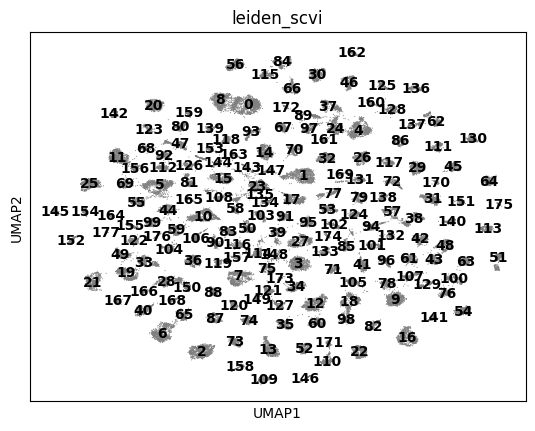

CPU times: user 2min 1s, sys: 3.91 s, total: 2min 4s
Wall time: 7min


In [20]:
%%time
sc.pp.neighbors(adata, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
sc.tl.leiden(adata, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=3)
sc.tl.umap(adata, neighbors_key='neighbors_scvi')
sc.pl.umap(adata, color=['leiden_scvi'], legend_loc='on data')

In [21]:
%%time
adata.write(cwd+'/outs/240101_kinker_scvi.h5ad')
scvi_model.save(cwd+'/outs/240101_kinker_scvi_model/', overwrite=True)

CPU times: user 417 ms, sys: 5.56 s, total: 5.98 s
Wall time: 36.9 s
